In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import hamming
import audio_functions as af
import plot


In [2]:
#Hacer un material desde cero
center_freqs = [125, 250, 500, 1000, 2000, 4000]
my_wall = {"description":"test material", "coeffs":[0.9, 0.9, 0.9, 0.9, 0.9, 0.9], "center_freqs":[125, 250, 500, 1000, 2000, 4000]}
super_wall = pra.Material(my_wall)

hormigon = pra.Material({"description":"bloque de hormigón pintado", "coeffs":[0.36, 0.44, 0.31, 0.29, 0.39, 0.25], "center_freqs":center_freqs})
madera = pra.Material({"description":"madera sobre viga", "coeffs":[0.2, 0.15, 0.1, 0.08, 0.08, 0.05], "center_freqs":center_freqs})
azulejo = pra.Material({"description":"azulejo", "coeffs":[0.01, 0.01, 0.01, 0.01, 0.02, 0.02], "center_freqs":center_freqs})


#Hacer un material a partir de la lista de materiales que están en la base de datos de pyroom
concrete = pra.Material('rough_concrete')
wood = pra.Material('wood_1.6cm')
ceramic = pra.Material('ceramic_tiles')
panel_abs = pra.Material("panel_fabric_covered_8pcf")

#Hacer un "material" a partir de una absorción promedio del recinto
abs_prom = pra.Material(0.3)


In [4]:
#Cargo el audio anecoico
audio, fs = af.load_audio("audios_anecoicos/p336_023.wav")
t_anecoico = np.arange(len(audio))/fs
signal = {"time vector":t_anecoico, "signal":audio, "label":"Audio Anecoico"}

#Genero una señal senoidal para pruebas
f = 500
#t = af.generate_time_vector(2, fs)
sen = 3*np.sin(2*np.pi*f*t)
seno = {'time vector':t, 'signal':sen}


plot.plot_signal(signal)
#plot.plot_signal(seno, figsize=(15, 2))
af.play_audio(audio, fs)
af.play_audio(sen, fs)

NameError: name 't' is not defined

(0.0, 3.0)

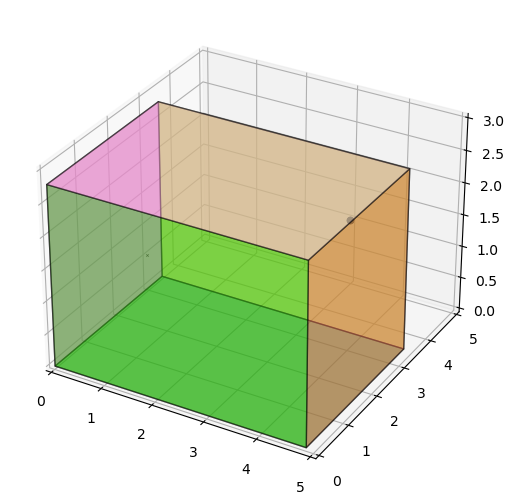

In [5]:
#Determino las dimensiones de la habitación y la frecuencia de sampleo a la cuál trabajar
room_dim = [4.86, 3.43, 2.80]
sup = 2*room_dim[0]*room_dim[1] + 2*room_dim[0]*room_dim[2] + 2*room_dim[1]*room_dim[2] #esto lo puse de yapa
fs = 48000

#Armo un diccionario especificando el material para cada superficie del cuarto
materials = {'east':hormigon, 'west':hormigon, 'north':hormigon, 'south':hormigon, 'ceiling':madera, 'floor':azulejo}

#Creo la habitación en formato shoebox
room = pra.ShoeBox(room_dim, fs=fs, max_order=100, materials=abs_prom)

#Agrego fuente y micrófono, se puede hacer al crear la habitación o agregar después
room.add_source([4., 3., 2.], signal=audio, delay=0.05)
room.add_microphone([1., 1.4, 1.4], fs=fs)

fig, ax = room.plot(mic_marker_size=3, source_marker_size=30)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,3])

<class 'pyroomacoustics.room.ShoeBox'>
<class 'numpy.ndarray'>
(1, 724096)
The RT60 is 401 ms


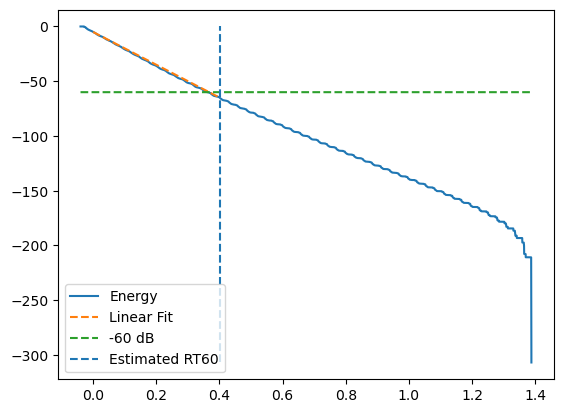

<Figure size 640x480 with 0 Axes>

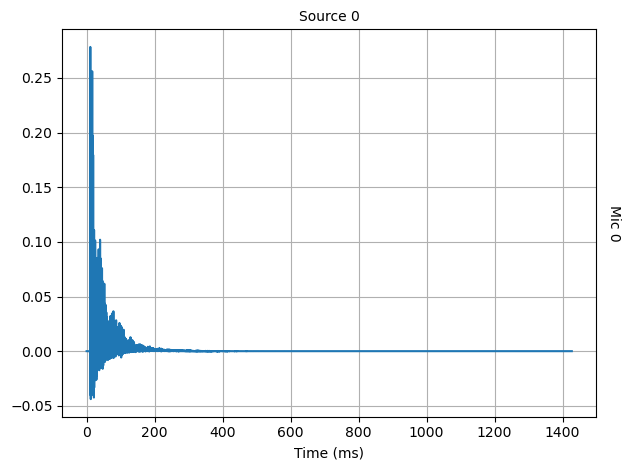

In [6]:
#Determino el modo de simulación para la rir y el T60
room.image_source_model()
#room.ray_tracing()

#Con simulate se simula la reproducción de la señal que cargas en la habitación (lo que nos interesa)
room.simulate()
print(type(room))
#Obtengo las grabaciones de los micrófonos
señales_captadas = room.mic_array.signals

print(type(señales_captadas))
print(señales_captadas.shape)

#Obtengo la rir
room.compute_rir()

#Obtengo el T60 a partir de la rir, cualquiera de los dos métodos anda más o menos (son una poronga)
#t60 = pra.experimental.rt60.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
t60 = room.measure_rt60(plot = True)

print(f"The RT60 is {t60[0, 0] * 1000:.0f} ms")


plt.figure()
room.plot_rir()
plt.grid()

#Notar que de las grabaciones tomo el 0, si hubieran más mics lo elijo a partir de ese índice
af.play_audio(señales_captadas[0], fs)


90
0.1956884899035521
The RT60 is 1337 ms


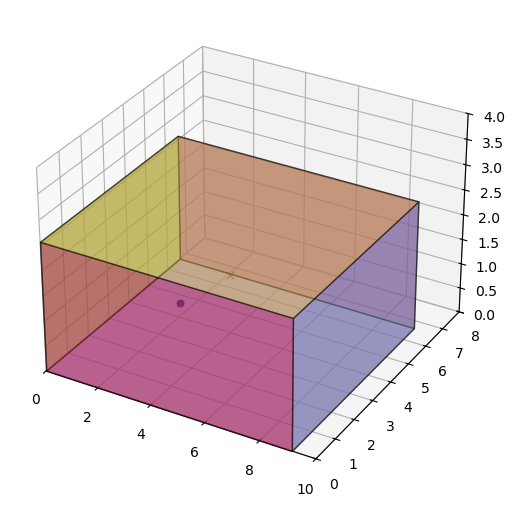

<Figure size 640x480 with 0 Axes>

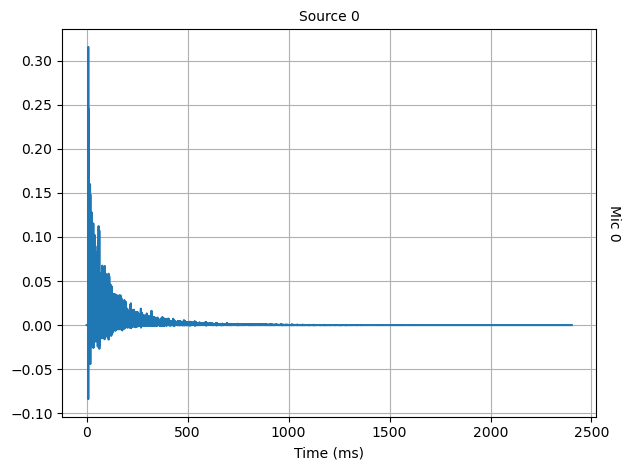

In [ ]:

rt60 = 0.636
roomdim = [9.15, 6.65, 2.58]
eabs, max_order = pra.inverse_sabine(rt60, roomdim)
eabs_est = 0.1754214847
print(max_order)
print(eabs)
martincito = pra.ShoeBox(roomdim, fs=fs, materials=pra.Material(eabs_est), max_order=90)

martincito.add_source([4., 1.5, 1.5])
martincito.add_microphone([4., 4., 1.2])

fig, ax = martincito.plot(mic_marker_size=30, source_marker_size=30)
ax.set_xlim([0,10])
ax.set_ylim([0,8])
ax.set_zlim([0,4])

martincito.image_source_model()
#room.ray_tracing()

martincito.compute_rir()

#t60 = pra.experimental.rt60(martincito.rir[0][0], fs=martincito.fs, plot=True)
rt60 = martincito.measure_rt60()
print(f"The RT60 is {rt60[0, 0] * 1000:.0f} ms")

#print(h.shape[0])

plt.figure()
martincito.plot_rir()
plt.grid()

af.play_audio(martincito.rir[0][0], fs)

### Lo siguiente es de un chad que sacó la rta en frec pero no me senté a analizar mucho

Num Frequency Bins 213
Standard Deviation 9.832863141615983
Min -28.482558932320327
Max 25.73450865686428
Delta 54.21706758918461


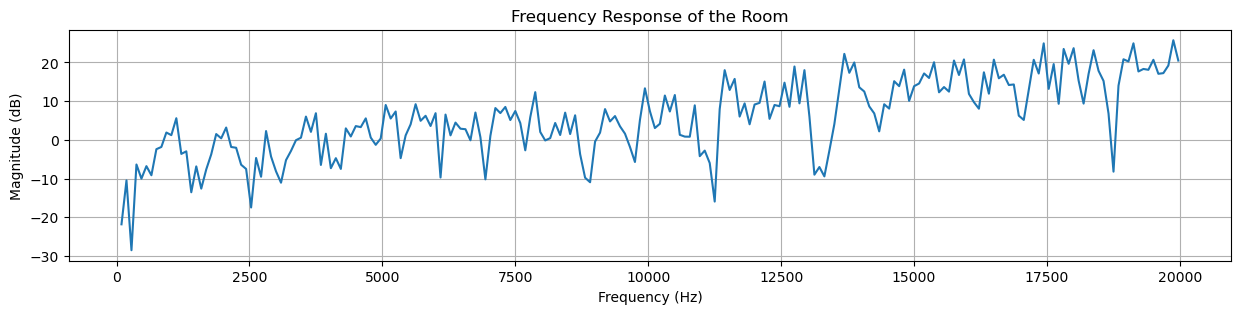

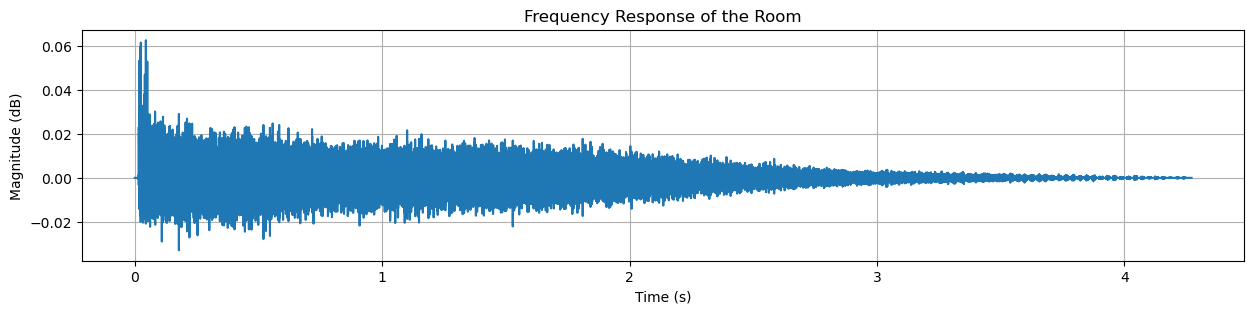

In [ ]:
# Define the chunk size.
chunk_size = 512
step_size = chunk_size // 2
min_freq = 20
max_freq = 20000

# Pad the impulse resonse so that our chunks start before and after the impulse response.
rir = room.rir[0][0]
rir = np.pad(rir, (step_size, len(rir) % chunk_size))
t = np.arange(len(rir))/fs


# Initialize an array to store the averaged frequency response
avg_freq_response = np.zeros(chunk_size, dtype=np.complex128)

# Apply Hamming window to each chunk, compute FFT, and average
for i, start_idx in enumerate(range(0, len(rir) - chunk_size, step_size)):
    end_idx = start_idx + chunk_size
    chunk = rir[start_idx:end_idx]

    # Apply Hamming window
    chunk *= hamming(chunk_size)

    # Compute FFT
    freq_response_chunk = np.fft.fft(chunk)
    avg_freq_response += freq_response_chunk

# Get frequency axis for our valid
freq_axis = np.fft.fftfreq(len(avg_freq_response), d=1/room.fs)

# Crop valid audible frequencies, so our statistics don't include inaudible frequencies
valid_freqs = np.logical_and(min_freq < freq_axis, freq_axis < max_freq)
freq_axis = freq_axis[valid_freqs]
freq_response = avg_freq_response[valid_freqs]
print('Num Frequency Bins', len(freq_axis))


# Convert to decibels
freq_response = 20 * np.log10(np.abs(freq_response))

print('Standard Deviation', freq_response.std())
print('Min', freq_response.min())
print('Max', freq_response.max())
print('Delta', freq_response.max() - freq_response.min())


# Plot the frequency response
plt.figure(figsize=(15,3))
plt.plot(freq_axis, freq_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of the Room')
plt.grid(True)

plt.figure(figsize=(15,3))
plt.plot(t, rir)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of the Room')
plt.grid(True)